In [1]:
from subprocess import Popen, PIPE
import getpass
username='EZAGAYNAYA'
REALM='BEE.VIMPELCOM.RU'
password = getpass.getpass(prompt='Enter Your Ldap password:\n')
kinit = 'kinit'
kinit_args = [ kinit, '%s@%s' % (username, REALM) ]
kinit = Popen(kinit_args, stdin=PIPE, stdout=PIPE, stderr=PIPE)
kinit.stdin.write(bytearray(password + "\n", "ascii"))
kinit.stdin.flush()
kinit.wait()

Enter Your Ldap password:
 ········


0

In [2]:
from pyspark import SparkConf  # noqa: E402
from pyspark.sql import DataFrame as SparkDataFrame  # noqa: E402
from pyspark.sql import SparkSession  # noqa: E402
from pyspark.sql import functions as F  # noqa: E402
from pyspark.sql.functions import col, when, min, max, sum, mean, count, substring, countDistinct, last_day, concat_ws 
from pyspark.sql.types import StringType, LongType

SPARK_SETTINGS = [
    ('spark.yarn.queue', 'default'),
        ('spark.sql.sources.partitionOverwriteMode', 'dynamic'),
        ('hive.exec.dynamic.partition', 'true'),
        ('hive.exec.dynamic.partition.mode', 'nonstrict'),
        ('spark.default.parallelism', '400'),
        ('spark.driver.memory', '20G'),
        ('spark.driver.memoryOverhead', '2G'),
        ('spark.driver.cores', 4),
        ('spark.driver.maxResultSize', '150G'),
        ('spark.dynamicAllocation.enabled', 'false'),
        ('spark.dynamicAllocation.maxExecutors', 200),
        ('spark.executor.memory', '20G'),
        ('spark.executor.memoryOverhead', '4G'),
        ('spark.executor.cores', 6),
        ('spark.executor.instances', 10),
        ('spark.hadoop.mapreduce.input.fileinputformat.input.dir.recursive', 'true'),
        ('spark.hive.mapred.supports.subdirectories', 'true'),# драйвер (понадобится для чтения из RDBMS)
        ('spark.kryoserializer.buffer', '1000m'),
        ('spark.kryoserializer.buffer.max', '2000m'),
        ('spark.rpc.message.maxSize', 2000),
        ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
        ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
        ('spark.sql.shuffle.partitions', '400'),
        ('spark.driver.extraClassPath', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'), # драйвер (понадобится для чтения из RDBMS)
        ('spark.jars', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'),
        ("spark.sql.hive.convertMetastoreOrc", " false"),
        ('spark.app.name', 'SVFomenkov_testing_pipeline')
]

app_name = 'ZEM_spark_session'

conf = SparkConf().setAppName(app_name).setMaster('yarn').setAll(SPARK_SETTINGS)
spark = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel('ERROR')
spark.conf.set("spark.sql.hive.convertMetastoreOrc", " false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/08 10:34:52 WARN HiveConf: HiveConf of name hive.mapred.supports.subdirectories does not exist
25/10/08 10:34:54 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
from IPython.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

/tmp/ipykernel_8032/3383840084.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### Pandas

In [4]:
import pandas as pd
import numpy as np
import scipy as sp

import pickle
# import shap

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, datasets, linear_model, metrics

import seaborn as sns

import datetime as dt
from datetime import datetime
from datetime import date
import math

# TF-IDF:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['max', 'datetime', 'sum', 'mean', 'min']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
# df_PD.to_pickle('df_churn_all.pkl')
df_PD = pd.read_pickle('df_churn_all.pkl')

print(df_PD.shape)
df_PD.head(2)

# (80000219, 29)

(80000219, 29)


,subscriber_sk,week_of_year,subs_market_cd,voice_min_1_H_avg,voice_min_2_H_avg,voice_min_1_R_avg,voice_min_2_R_avg,gprs_mb_3_H_avg,gprs_mb_3_R_avg,reason_1,...,price_plan_type_max,repr2q2025_max,churn_flg,voice_min_1_H_countNA,voice_min_2_H_countNA,voice_min_1_R_countNA,voice_min_2_R_countNA,gprs_mb_3_H_countNA,gprs_mb_3_R_countNA,prev_churn_flg
0,254,22,VIP,0.566667,0.000000,0.0,0.0,346.710001,0.0,None,...,Bundle,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,254,23,VIP,1.411905,2.635714,0.0,0.0,196.384286,0.0,None,...,Bundle,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_PD_churn_sk = list( df_PD[df_PD['churn_flg'] == 1]['subscriber_sk'].drop_duplicates() )
len(df_PD_churn_sk)

70297

In [7]:
df_PD.columns

Index(['subscriber_sk', 'week_of_year', 'subs_market_cd', 'voice_min_1_H_avg',
       'voice_min_2_H_avg', 'voice_min_1_R_avg', 'voice_min_2_R_avg',
       'gprs_mb_3_H_avg', 'gprs_mb_3_R_avg', 'reason_1', 'reason_2',
       'reason_3', 'calls_sum', 'dialog_time_sum', 'req_qnt_sum',
       'active_days_sum', 'bad_days_sum', 'accept_days_sum', 'good_days_sum',
       'price_plan_type_max', 'repr2q2025_max', 'churn_flg',
       'voice_min_1_H_countNA', 'voice_min_2_H_countNA',
       'voice_min_1_R_countNA', 'voice_min_2_R_countNA', 'gprs_mb_3_H_countNA',
       'gprs_mb_3_R_countNA', 'prev_churn_flg'],
      dtype='object')

In [19]:
# df_churn = df_PD[ df_PD['subscriber_sk'].isin(df_PD_churn_sk) ].sort_values(by = ['subscriber_sk', 'week_of_year'])
# df_churn = df_churn.reset_index(drop = True)

# df_churn = df_churn[['subscriber_sk', 'week_of_year', 'subs_market_cd', 'voice_min_1_H_avg',
#                        'voice_min_2_H_avg', 'voice_min_1_R_avg', 'voice_min_2_R_avg',
#                        'gprs_mb_3_H_avg', 'gprs_mb_3_R_avg', 'reason_1', 'reason_2',
#                        'reason_3', 'calls_sum', 'dialog_time_sum', 'req_qnt_sum',
#                        'active_days_sum', 'bad_days_sum', 'accept_days_sum', 'good_days_sum',
#                        'price_plan_type_max', 'repr2q2025_max',
#                        'voice_min_1_H_countNA', 'voice_min_2_H_countNA',
#                        'voice_min_1_R_countNA', 'voice_min_2_R_countNA', 'gprs_mb_3_H_countNA',
#                        'gprs_mb_3_R_countNA', 'churn_flg', 'prev_churn_flg']]

list_var_dec_30 = ['voice_min_1_H_avg', 'voice_min_2_H_avg', 'voice_min_1_R_avg', 'voice_min_2_R_avg',
                   'gprs_mb_3_H_avg', 'gprs_mb_3_R_avg']

for i in list_var_dec_30:
    df_PD[i + '_next'] = df_PD.groupby(['subscriber_sk'])[i].shift(-1)
    df_PD[i + '_delta_part'] = (df_PD[i + '_next'] - df_PD[i]) / df_PD[i]
    df_PD[i + '_gr30'] = df_PD[i + '_delta_part'].apply(lambda x: 1 if x <= -0.3 else 0)
    df_PD[i + '_gr30' + '_sum'] = df_PD.groupby(['subscriber_sk'])[i + '_gr30'].transform('sum')

print(df_PD.shape)
df_PD.head()

(80000219, 53)


,subscriber_sk,week_of_year,subs_market_cd,voice_min_1_H_avg,voice_min_2_H_avg,voice_min_1_R_avg,voice_min_2_R_avg,gprs_mb_3_H_avg,gprs_mb_3_R_avg,reason_1,...,voice_min_2_R_avg_gr30,voice_min_2_R_avg_gr30_sum,gprs_mb_3_H_avg_next,gprs_mb_3_H_avg_delta_part,gprs_mb_3_H_avg_gr30,gprs_mb_3_H_avg_gr30_sum,gprs_mb_3_R_avg_next,gprs_mb_3_R_avg_delta_part,gprs_mb_3_R_avg_gr30,gprs_mb_3_R_avg_gr30_sum
0,254,22,VIP,0.566667,0.000000,0.0,0.000000,346.710001,0.0,None,...,0,5,196.384286,-0.433578,1,5,0.0,NaN,0,0
1,254,23,VIP,1.411905,2.635714,0.0,0.000000,196.384286,0.0,None,...,0,5,357.334445,0.819567,0,5,0.0,NaN,0,0
2,254,24,VIP,0.044444,0.833333,0.0,0.827778,357.334445,0.0,None,...,0,5,308.095003,-0.137797,0,5,0.0,NaN,0,0
3,254,25,VIP,1.408333,2.166667,0.0,1.186667,308.095003,0.0,None,...,1,5,253.252863,-0.178004,0,5,0.0,NaN,0,0
4,254,26,VIP,2.242857,3.452381,0.0,0.000000,253.252863,0.0,None,...,0,5,161.435720,-0.362551,1,5,0.0,NaN,0,0


In [20]:
df_PD[['subscriber_sk',	'week_of_year', 'voice_min_1_H_avg', 'voice_min_1_H_avg_next', 'voice_min_1_H_avg_delta_part', 'voice_min_1_H_avg_gr30', 'voice_min_1_H_avg_gr30_sum']].head(25)

,subscriber_sk,week_of_year,voice_min_1_H_avg,voice_min_1_H_avg_next,voice_min_1_H_avg_delta_part,voice_min_1_H_avg_gr30,voice_min_1_H_avg_gr30_sum
0,254,22,0.566667,1.411905,1.491595,0,5
1,254,23,1.411905,0.044444,-0.968522,1,5
2,254,24,0.044444,1.408333,30.687495,0,5
3,254,25,1.408333,2.242857,0.592562,0,5
4,254,26,2.242857,2.350000,0.047771,0,5
5,254,27,2.350000,0.037037,-0.984240,1,5
6,254,28,0.037037,0.000000,-1.000000,1,5
7,254,29,0.000000,0.526190,inf,0,5
8,254,30,0.526190,3.711111,6.052791,0,5
9,254,31,3.711111,0.726667,-0.804192,1,5


In [21]:
df_PD.drop(['voice_min_1_H_avg_next', 'voice_min_1_H_avg_delta_part', 'voice_min_1_H_avg_gr30', 
               'voice_min_2_H_avg_next', 'voice_min_2_H_avg_delta_part', 'voice_min_2_H_avg_gr30',
               'voice_min_1_R_avg_next', 'voice_min_1_R_avg_delta_part', 'voice_min_1_R_avg_gr30', 
               'voice_min_2_R_avg_next', 'voice_min_2_R_avg_delta_part', 'voice_min_2_R_avg_gr30', 
               'gprs_mb_3_H_avg_next', 'gprs_mb_3_H_avg_delta_part', 'gprs_mb_3_H_avg_gr30', 
               'gprs_mb_3_R_avg_next', 'gprs_mb_3_R_avg_delta_part', 'gprs_mb_3_R_avg_gr30'], axis = 1, inplace = True)

In [22]:
df_PD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000219 entries, 0 to 80000218
Data columns (total 35 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   subscriber_sk               int64  
 1   week_of_year                int32  
 2   subs_market_cd              object 
 3   voice_min_1_H_avg           float64
 4   voice_min_2_H_avg           float64
 5   voice_min_1_R_avg           float64
 6   voice_min_2_R_avg           float64
 7   gprs_mb_3_H_avg             float64
 8   gprs_mb_3_R_avg             float64
 9   reason_1                    object 
 10  reason_2                    object 
 11  reason_3                    object 
 12  calls_sum                   float64
 13  dialog_time_sum             float64
 14  req_qnt_sum                 float64
 15  active_days_sum             float64
 16  bad_days_sum                float64
 17  accept_days_sum             float64
 18  good_days_sum               float64
 19  price_plan_type_max

In [23]:
# df_churn[['voice_min_1_H_countNA', 'voice_min_2_H_countNA', 'voice_min_1_R_countNA', 'voice_min_2_R_countNA', 'gprs_mb_3_H_countNA', 'gprs_mb_3_R_countNA']].drop_duplicates()

In [24]:
df_PD.shape

(80000219, 35)

In [25]:
# ******************************************************** Spark download: *******************************************************
from pyspark.sql.types import StringType, FloatType, LongType, ByteType, ArrayType, StructType, StructField, IntegerType, DateType

In [26]:
# спарк датафрейм создавать, например, вот так:

mySchema = StructType(
    [
        StructField("subscriber_sk", IntegerType(), True)
        ,StructField("week_of_year", IntegerType(), True)
        ,StructField("subs_market_cd", StringType(), True)
        ,StructField("voice_min_1_H_avg", FloatType(), True)
        ,StructField("voice_min_2_H_avg", FloatType(), True)
        ,StructField("voice_min_1_R_avg", FloatType(), True)
        ,StructField("voice_min_2_R_avg", FloatType(), True)
        ,StructField("gprs_mb_3_H_avg", FloatType(), True)
        ,StructField("gprs_mb_3_R_avg", FloatType(), True)
        ,StructField("reason_1", StringType(), True)
        ,StructField("reason_2", StringType(), True)
        ,StructField("reason_3", StringType(), True)
        ,StructField("calls_sum", FloatType(), True)
        ,StructField("dialog_time_sum", FloatType(), True)
        ,StructField("req_qnt_sum", FloatType(), True)
        ,StructField("active_days_sum", FloatType(), True)
        ,StructField("bad_days_sum", FloatType(), True)
        ,StructField("accept_days_sum", FloatType(), True)
        ,StructField("good_days_sum", FloatType(), True)
        ,StructField("price_plan_type_max", StringType(), True)
        ,StructField("repr2q2025_max", IntegerType(), True)
        ,StructField("voice_min_1_H_countNA", FloatType(), True)
        ,StructField("voice_min_2_H_countNA", FloatType(), True)
        ,StructField("voice_min_1_R_countNA", FloatType(), True)
        ,StructField("voice_min_2_R_countNA", FloatType(), True)
        ,StructField("gprs_mb_3_H_countNA", FloatType(), True)
        ,StructField("gprs_mb_3_R_countNA", FloatType(), True)
        ,StructField("churn_flg", FloatType(), True)
        ,StructField("prev_churn_flg", FloatType(), True)
        ,StructField("voice_min_1_H_avg_gr30_sum", IntegerType(), True)
        ,StructField("voice_min_2_H_avg_gr30_sum", IntegerType(), True)
        ,StructField("voice_min_1_R_avg_gr30_sum", IntegerType(), True)
        ,StructField("voice_min_2_R_avg_gr30_sum", IntegerType(), True)
        ,StructField("gprs_mb_3_H_avg_gr30_sum", IntegerType(), True)
        ,StructField("gprs_mb_3_R_avg_gr30_sum", IntegerType(), True)
    ]
)
                   
# X_out_sdf = spark.createDataFrame(X_out_2, schema = mySchema)
X_out_sdf = spark.createDataFrame(df_PD, schema = mySchema)

In [27]:
# resulting_table = 'b2b_stg.df_only_churn_sk'

resulting_table = 'b2b_stg.df_churn_all_agg_3'

db_name, table_name = resulting_table.split(".")
   
(
    X_out_sdf
    .repartition(40)
    .write.mode("overwrite")
    .format("parquet")
    .option("path", f"hdfs://ns-etl/warehouse/tablespace/external/hive/{db_name}.db/{table_name}")
    .saveAsTable(resulting_table)
)

In [28]:
df_check = spark.read.table('b2b_stg.df_churn_all_agg_3') 
print('num_rows:', df_check.count())
print('num_cols:', len(df_check.columns))
df_check.show(3)

# num_rows: (80000219, 35)

num_rows: 80000219
num_cols: 35


+-------------+------------+--------------+-----------------+-----------------+-----------------+-----------------+---------------+---------------+--------+--------+--------+---------+---------------+-----------+---------------+------------+---------------+-------------+-------------------+--------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+---------+--------------+--------------------------+--------------------------+--------------------------+--------------------------+------------------------+------------------------+
|subscriber_sk|week_of_year|subs_market_cd|voice_min_1_H_avg|voice_min_2_H_avg|voice_min_1_R_avg|voice_min_2_R_avg|gprs_mb_3_H_avg|gprs_mb_3_R_avg|reason_1|reason_2|reason_3|calls_sum|dialog_time_sum|req_qnt_sum|active_days_sum|bad_days_sum|accept_days_sum|good_days_sum|price_plan_type_max|repr2q2025_max|voice_min_1_H_countNA|voice_min_2_H_countNA|voice_min_1_R_countNA|voice_min_

In [ ]:
# *****************************************************************************************************************************************************************************

In [35]:
df_PD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000219 entries, 0 to 80000218
Data columns (total 38 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   subscriber_sk               int64  
 1   week_of_year                int32  
 2   subs_market_cd              object 
 3   voice_min_1_H_avg           float64
 4   voice_min_2_H_avg           float64
 5   voice_min_1_R_avg           float64
 6   voice_min_2_R_avg           float64
 7   gprs_mb_3_H_avg             float64
 8   gprs_mb_3_R_avg             float64
 9   reason_1                    object 
 10  reason_2                    object 
 11  reason_3                    object 
 12  calls_sum                   float64
 13  dialog_time_sum             float64
 14  req_qnt_sum                 float64
 15  active_days_sum             float64
 16  bad_days_sum                float64
 17  accept_days_sum             float64
 18  good_days_sum               float64
 19  repr2q2025_max     

##### Dummies

In [31]:
categ_columns = ['price_plan_type_max']

for column in categ_columns: 
    
    dummies = pd.get_dummies(df_PD[column], prefix = column)
    df_PD[dummies.columns] = dummies
    df_PD.drop([column], inplace = True, axis = 1)

##### TF-IDF Vectorization

In [32]:
import sklearn.feature_extraction.text

from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
# df_PD.head(3)

In [36]:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

print('df_PD.shape:', df_PD.shape)

# ******************* List of features: ***************************
all_features = ['subs_market_cd', 'reason_1', 'reason_2', 'reason_3']

for i in range(len(all_features)):
    
    feature = all_features[i]
    texts = df_PD[feature].fillna('-1')

    print(feature)
    
    # Initialize TF-IDF model:
    vectorizer = TfidfVectorizer(max_features = 5)
    
    # Fit and transform:
    tfidf_matrix = vectorizer.fit_transform(texts)

    # ******************* save model transformer 07.10.25: ********************
    with open('TF_IDF_vectorizer_churn_3_' + feature + '.pkl', 'wb') as fid:
            pickle.dump(vectorizer, fid)
    
    # Convert to DataFrame:
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())

    tfidf_df.columns = [feature + '_' + col for col in tfidf_df.columns ]

    df_PD.drop(feature, axis = 1, inplace = True)
    df_PD = pd.concat([df_PD, tfidf_df], axis = 1)

print(df_PD.shape)
df_PD.head(3)

df_PD.shape: (80000219, 38)
subs_market_cd
reason_1
reason_2
reason_3
(80000219, 54)


,subscriber_sk,week_of_year,voice_min_1_H_avg,voice_min_2_H_avg,voice_min_1_R_avg,voice_min_2_R_avg,gprs_mb_3_H_avg,gprs_mb_3_R_avg,calls_sum,dialog_time_sum,...,reason_2_голос,reason_2_интернет,reason_2_не,reason_2_после,reason_2_работает,reason_3_консультация,reason_3_настройки,reason_3_не,reason_3_сети,reason_3_устройства
0,254,22,0.566667,0.000000,0.0,0.000000,346.710001,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,254,23,1.411905,2.635714,0.0,0.000000,196.384286,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,254,24,0.044444,0.833333,0.0,0.827778,357.334445,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
54 - 38

16

#### Pandas

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import pickle
# import shap

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, datasets, linear_model, metrics

import seaborn as sns

import datetime as dt
from datetime import datetime
from datetime import date
import math

# TF-IDF:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### Dataset

In [2]:
# df_PD.to_pickle('df_churn_all_processed.pkl')
df_PD = pd.read_pickle('df_churn_all_processed.pkl')

print(df_PD.shape)
df_PD.head(2)

# (80000219, 54)

(80000219, 54)


,subscriber_sk,week_of_year,voice_min_1_H_avg,voice_min_2_H_avg,voice_min_1_R_avg,voice_min_2_R_avg,gprs_mb_3_H_avg,gprs_mb_3_R_avg,calls_sum,dialog_time_sum,...,reason_2_голос,reason_2_интернет,reason_2_не,reason_2_после,reason_2_работает,reason_3_консультация,reason_3_настройки,reason_3_не,reason_3_сети,reason_3_устройства
0,254,22,0.566667,0.000000,0.0,0.0,346.710001,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,254,23,1.411905,2.635714,0.0,0.0,196.384286,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# df_PD.info()

In [4]:
# df_PD[['subscriber_sk', 'week_of_year', 'churn_flg', 'prev_churn_flg']]

df_PD['target'] = df_PD.groupby(['subscriber_sk'])['churn_flg'].shift(-2)
df_PD[['subscriber_sk', 'week_of_year', 'churn_flg', 'target']]

,subscriber_sk,week_of_year,churn_flg,target
0,254,22,0.0,0.0
1,254,23,0.0,0.0
2,254,24,0.0,0.0
3,254,25,0.0,0.0
4,254,26,0.0,0.0
...,...,...,...,...
80000214,587965905,38,0.0,NaN
80000215,587966170,38,0.0,NaN
80000216,587966551,38,0.0,NaN
80000217,587967096,38,0.0,NaN


In [5]:
df_PD[['subscriber_sk', 'week_of_year', 'churn_flg', 'target']].head(25)

,subscriber_sk,week_of_year,churn_flg,target
0,254,22,0.0,0.0
1,254,23,0.0,0.0
2,254,24,0.0,0.0
3,254,25,0.0,0.0
4,254,26,0.0,0.0
5,254,27,0.0,0.0
6,254,28,0.0,0.0
7,254,29,0.0,0.0
8,254,30,0.0,0.0
9,254,31,0.0,0.0


#### X y

In [6]:
# X = df_PD[df_PD['prev_churn_flg'].isna() == False].drop(['subscriber_sk', 'week_of_year', 'churn_flg', 'prev_churn_flg'], axis = 1)

X = df_PD[df_PD['target'].isna() == False].drop(['subscriber_sk', 'week_of_year', 'churn_flg', 'prev_churn_flg', 'target'], axis = 1)

In [7]:
# y = df_PD[df_PD['prev_churn_flg'].isna() == False]['prev_churn_flg']

y = df_PD[df_PD['target'].isna() == False]['target']

In [8]:
df_PD[df_PD['week_of_year'] == 37].shape[0]

4938274

In [9]:
df_PD[(df_PD['week_of_year'] == 37) & (df_PD['target'] == 1)].shape[0]

0

In [10]:
1514/4938274 * 100

0.030658485130634714

In [11]:
num_unique = pd.DataFrame(X.nunique())
num_unique.rename(columns = {0: 'num_unique'}, inplace = True)

cols_drop = list(num_unique[num_unique['num_unique'] == 1].index)
cols_drop

X.drop(cols_drop, axis = 1, inplace = True)

#### Features selection

In [12]:
# ********* Gini of factors: *********

feature_columns = X.columns
print(len(feature_columns))

43


In [13]:
d_gini_by_feature = {}

for feature in feature_columns:

    # print(feature)
    
    min_value = X[feature].min()
    
    if min_value >= 0:
        auc = roc_auc_score(y, X[feature].fillna(-9999))
        
    else:
        idx = X[feature].notna()
        auc = roc_auc_score(y[idx], X[feature][idx])        
    
    max_auc = auc if auc > (1 - auc) else (1 - auc)
#   gini = 2 * max(auc, 1 - auc) - 1
    gini = 2 * max_auc - 1
    
    d_gini_by_feature[feature] = gini

# d_gini_by_feature
# ******************************************************************

gini_by_feature = pd.DataFrame(d_gini_by_feature, index = ['gini']).T

gini_by_feature = gini_by_feature.sort_values('gini', ascending = False)
gini_by_feature

,gini
gprs_mb_3_H_avg_gr30_sum,0.398977
gprs_mb_3_H_avg,0.389510
voice_min_1_H_avg_gr30_sum,0.325054
voice_min_1_R_avg,0.322844
voice_min_2_H_avg_gr30_sum,0.304595
price_plan_type_max_Other,0.271923
active_days_sum,0.239866
price_plan_type_max_Bundle,0.213773
voice_min_2_H_avg,0.198134
voice_min_2_R_avg_gr30_sum,0.175109


array([[<Axes: title={'center': 'gini'}>]], dtype=object)

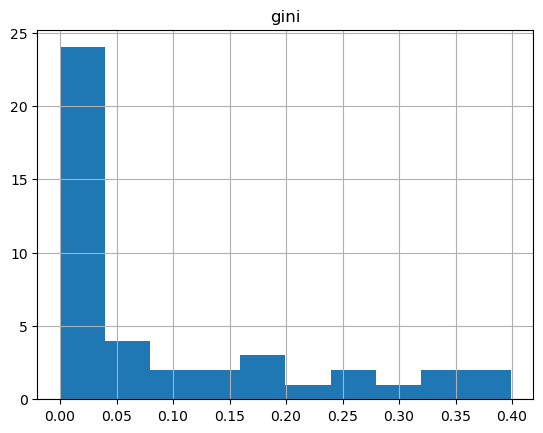

In [14]:
gini_by_feature[gini_by_feature['gini'] != 0].hist()

In [15]:
gini_by_feature.reset_index()

,index,gini
0,gprs_mb_3_H_avg_gr30_sum,0.398977
1,gprs_mb_3_H_avg,0.389510
2,voice_min_1_H_avg_gr30_sum,0.325054
3,voice_min_1_R_avg,0.322844
4,voice_min_2_H_avg_gr30_sum,0.304595
5,price_plan_type_max_Other,0.271923
6,active_days_sum,0.239866
7,price_plan_type_max_Bundle,0.213773
8,voice_min_2_H_avg,0.198134
9,voice_min_2_R_avg_gr30_sum,0.175109


In [16]:
feature_columns = gini_by_feature.loc[(gini_by_feature['gini'] > 0.000182)].index.tolist()
        
print('Оставляем {} фичей из {}'.format(len(feature_columns), gini_by_feature.shape[0]))
feature_columns

print(X.shape)
X = X[feature_columns]
print(X.shape)

Оставляем 32 фичей из 43
(62626698, 43)
(62626698, 32)


#### Correlations

In [17]:
# Выведем матрицу корреляций и удалим зависиммые переменные:

plt.figure(figsize = (15, 15))

cor = X.corr()
# sns.heatmap(cor, annot = True, cmap = plt.cm.Reds)
# plt.show()

<Figure size 1500x1500 with 0 Axes>

In [18]:
cnt = 0

for i in range(0, cor.shape[0]):
    for j in range(0, cor.shape[1]):
        
#         if (i > j) & (abs(cor.iloc[i,j]) > 0.9):
        if (i > j) & ( (cor.iloc[i,j] > 0.9) | (cor.iloc[i,j] < -0.9) ):
            cnt += 1
            print('corr(', cor.index[i], ',', cor.columns[j], ') = ', cor.iloc[i][j])
        
print(cnt) 

corr( reason_1_связи , reason_1_качество ) =  1.0
1


In [19]:
# + Удаление сильно коррелирующих признаков

THRESHOLD_FOR_CORRELATION = 0.9

feature_columns = list(X.columns)

# correlation_matrix = df[L1_columns].corr()
correlation_matrix = X.corr()

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > THRESHOLD_FOR_CORRELATION)]

feature_after_corr = [col for col in feature_columns if col not in to_drop]

print('По корреляции оставляем {} фичей из {}'.format( len(feature_after_corr), len(feature_columns) ))

По корреляции оставляем 31 фичей из 32


In [20]:
print(len(feature_after_corr))
feature_after_corr

31


['gprs_mb_3_H_avg_gr30_sum',
 'gprs_mb_3_H_avg',
 'voice_min_1_H_avg_gr30_sum',
 'voice_min_1_R_avg',
 'voice_min_2_H_avg_gr30_sum',
 'price_plan_type_max_Other',
 'active_days_sum',
 'price_plan_type_max_Bundle',
 'voice_min_2_H_avg',
 'voice_min_2_R_avg_gr30_sum',
 'voice_min_1_H_avg',
 'good_days_sum',
 'accept_days_sum',
 'bad_days_sum',
 'voice_min_1_R_avg_gr30_sum',
 'repr2q2025_max',
 'subs_market_cd_vip',
 'voice_min_2_R_avg',
 'price_plan_type_max_Line',
 'subs_market_cd_ekt',
 'gprs_mb_3_R_avg_gr30_sum',
 'subs_market_cd_kzn',
 'price_plan_type_max_Data',
 'subs_market_cd_ufa',
 'subs_market_cd_spb',
 'gprs_mb_3_R_avg',
 'calls_sum',
 'dialog_time_sum',
 'reason_3_консультация',
 'reason_2_не',
 'reason_1_качество']

In [ ]:
# # feature_importance = 0:
# gprs_mb_3_R_avg	
# reason_3_консультация	
# reason_2_не	
# reason_1_качество	
# dialog_time_sum	

In [32]:
# 31
feature_after_corr = ['gprs_mb_3_H_avg_gr30_sum',
 'gprs_mb_3_H_avg',
 'voice_min_1_H_avg_gr30_sum',
 'voice_min_1_R_avg',
 'voice_min_2_H_avg_gr30_sum',
 'price_plan_type_max_Other',
 'active_days_sum',
 'price_plan_type_max_Bundle',
 'voice_min_2_H_avg',
 'voice_min_2_R_avg_gr30_sum',
 'voice_min_1_H_avg',
 'good_days_sum',
 'accept_days_sum',
 'bad_days_sum',
 'voice_min_1_R_avg_gr30_sum',
 'repr2q2025_max',
 'subs_market_cd_vip',
 'voice_min_2_R_avg',
 'price_plan_type_max_Line',
 'subs_market_cd_ekt',
 'gprs_mb_3_R_avg_gr30_sum',
 'subs_market_cd_kzn',
 'price_plan_type_max_Data',
 'subs_market_cd_ufa',
 'subs_market_cd_spb',
 # 'gprs_mb_3_R_avg',
 'calls_sum',
 # 'dialog_time_sum',
 # 'reason_3_консультация',
 # 'reason_2_не',
 # 'reason_1_качество'
]

print(len(feature_after_corr))

26


In [33]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

model_features = feature_after_corr

X_train, X_test, y_train, y_test = train_test_split(X[model_features], y, test_size = 0.2, random_state = 42, stratify = y)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

(50101358, 26) (12525340, 26)
0.0006739138687618008 0.0006739138418597818


In [34]:
# clf_lgb = lgb.LGBMClassifier() 
clf_lgb = lgb.LGBMClassifier(class_weight = 'balanced')     


clf_lgb.fit(X_train, y_train)

print('\n')
y_pred_train = clf_lgb.predict_proba(X_train)[:,1]
AUC_train = metrics.roc_auc_score(y_train, y_pred_train)
Gini_train = 2 * AUC_train - 1
print('AUC_train:', AUC_train)
print('Gini_train:', Gini_train)

print()

y_pred_test = clf_lgb.predict_proba(X_test)[:,1]
AUC_test = metrics.roc_auc_score(y_test, y_pred_test)
Gini_test = 2 * AUC_test - 1
print('AUC_test:', AUC_test)
print('Gini_test:', Gini_test)

# *** 30 features (balanced): ***

# AUC_train: 0.9006080093587845
# Gini_train: 0.801216018717569

# AUC_test: 0.8941734082637222
# Gini_test: 0.7883468165274443

[LightGBM] [Info] Number of positive: 33764, number of negative: 50067594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.705251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 50101358, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


AUC_train: 0.9006080093587845
Gini_train: 0.801216018717569

AUC_test: 0.8941734082637222
Gini_test: 0.7883468165274443


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


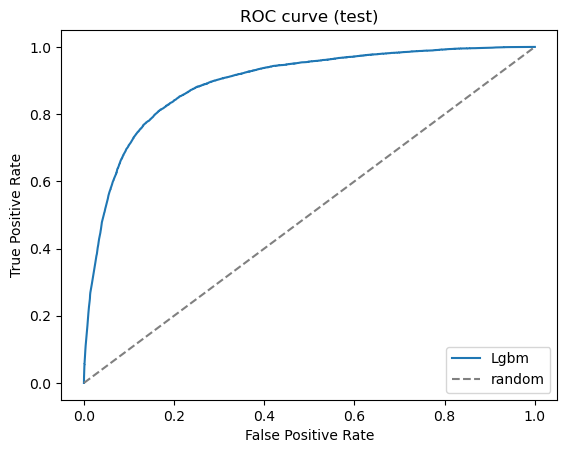

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test)

pylab.plot(fpr, tpr, label = 'Lgbm')
pylab.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve (test)')
pylab.legend(loc = "lower right")

In [36]:
# from sklearn import model_selection, datasets, linear_model, metrics

# # kfold = model_selection.KFold(n_splits = 4)
# skf = StratifiedKFold(n_splits = 4)

# # AUC_cv = cross_val_score(clf_lgb, X[features_list], y, cv = kfold, scoring = 'roc_auc', n_jobs = -1)
# AUC_cv = cross_val_score(clf_lgb, X, y, cv = skf, scoring = 'roc_auc', n_jobs = -1)
# AUC_cv

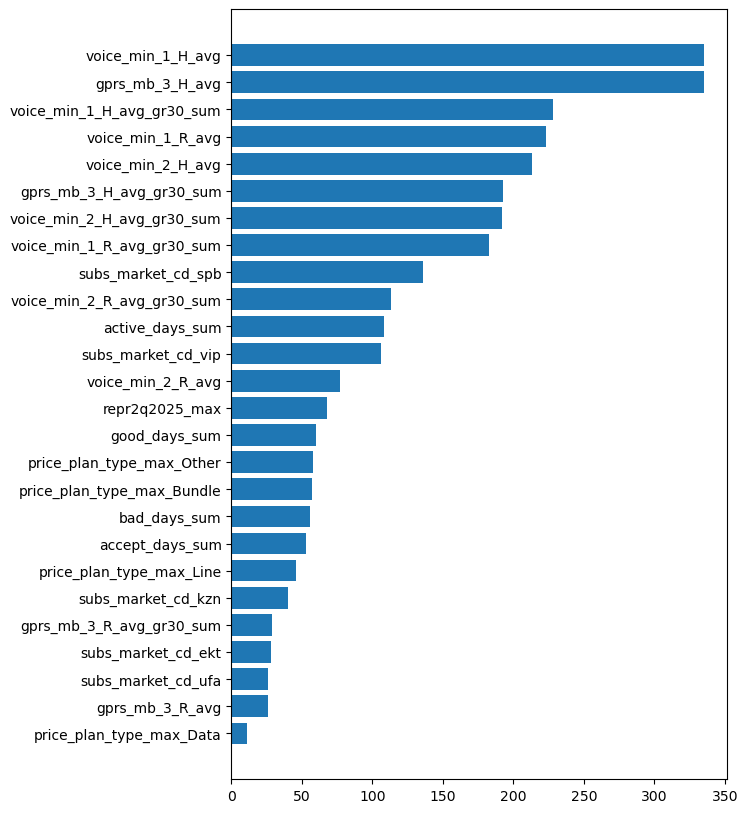

In [37]:
importances = clf_lgb.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots()

ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))

_ = ax.set_yticklabels(np.array(X.columns)[indices])

fig.set_figheight(10)

In [38]:
variable_importance = pd.DataFrame(sorted(zip(clf_lgb.feature_importances_, feature_columns), reverse=True))
variable_importance.columns = ['gain', 'feature']

variable_importance['gain_share'] = variable_importance['gain'] / variable_importance['gain'].sum()

variable_importance = variable_importance[['feature', 'gain', 'gain_share']]

variable_importance

,feature,gain,gain_share
0,voice_min_1_H_avg,335,0.111667
1,gprs_mb_3_H_avg,335,0.111667
2,voice_min_1_H_avg_gr30_sum,228,0.076000
3,voice_min_1_R_avg,223,0.074333
4,voice_min_2_H_avg,213,0.071000
5,gprs_mb_3_H_avg_gr30_sum,193,0.064333
6,voice_min_2_H_avg_gr30_sum,192,0.064000
7,voice_min_1_R_avg_gr30_sum,183,0.061000
8,subs_market_cd_spb,136,0.045333
9,voice_min_2_R_avg_gr30_sum,113,0.037667


In [39]:
import pickle

# *************** save model 08.10.25: *****************

# with open('model_churn.pkl', 'wb') as fid:

#         pickle.dump(clf_lgb, fid)

# ********************** read: ***********************

# with open('model_churn.pkl', 'rb') as fid:
    
#     clf_lgb_saved = pickle.load(fid)

In [41]:
# predict 0 1:
y_pred_train_class = clf_lgb.predict(X_train)
AUC_train_class = metrics.roc_auc_score(y_train, y_pred_train_class)

Gini_train_class = 2 * AUC_train_class - 1
print('AUC_train_class:', AUC_train_class)
print('Gini_train_class:', Gini_train_class)

print()

y_pred_test_class = clf_lgb.predict(X_test)
AUC_test_class = metrics.roc_auc_score(y_test, y_pred_test_class)
Gini_test_class = 2 * AUC_test_class - 1
print('AUC_test_class:', AUC_test_class)
print('Gini_test_class:', Gini_test_class)

# AUC_train_class: 0.8236501815599973
# Gini_train_class: 0.6473003631199945

# AUC_test_class: 0.8210497544268943
# Gini_test_class: 0.6420995088537886

AUC_train_class: 0.8236501815599973
Gini_train_class: 0.6473003631199945

AUC_test_class: 0.8210497544268943
Gini_test_class: 0.6420995088537886


In [42]:
cm = metrics.confusion_matrix(y_test, y_pred_test_class)
print(cm)

TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
print('TP:', TP)
print('FP:', FP)

[[10233224  2283675]
 [    1481     6960]]
TP: 6960
FP: 2283675


In [43]:
metrics.accuracy_score(y_test, y_pred_test_class)

0.8175573677041901

In [44]:
print(metrics.classification_report(y_test, y_pred_test_class))

              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90  12516899
         1.0       0.00      0.82      0.01      8441

    accuracy                           0.82  12525340
   macro avg       0.50      0.82      0.45  12525340
weighted avg       1.00      0.82      0.90  12525340



In [45]:
y_pred_all = clf_lgb.predict_proba(X[model_features])[:,1]

p, r, thresholds = precision_recall_curve(y, y_pred_all)

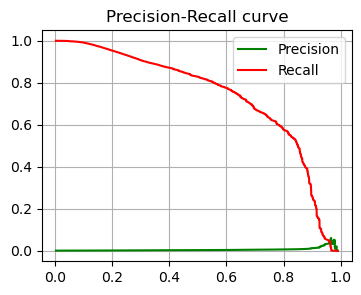

In [46]:
plt.figure(figsize = (4, 3))

plt.plot(thresholds, p[:-1], "g-", label = "Precision")
plt.plot(thresholds, r[:-1], "r-", label = "Recall")
plt.title('Precision-Recall curve')
plt.legend(loc = "upper right")
plt.grid()
plt.show()

In [47]:
y_pred_all_01 = pd.DataFrame(y_pred_all).rename(columns = {0: 'predict'})
y_pred_all_01 = y_pred_all_01['predict'].apply(lambda x: 1 if x >= 0.9 else 0)
# y_pred_all_01

In [48]:
confusion = metrics.confusion_matrix(y, y_pred_all_01)
confusion

array([[61731168,   853325],
       [   31336,    10869]])

In [49]:
# Precision:
# TP / TP + FP

Precision = confusion[1,1]/(confusion[0,1] + confusion[1,1])
Precision

0.012577037100465868

In [50]:
# Recall:
# TP / TP + FN

Recall = confusion[1,1]/(confusion[1,0] + confusion[1,1])
Recall

0.2575287288235991

In [51]:
F = 2 * Precision * Recall / (Precision + Recall)
F

0.02398281551502153

In [52]:
y_pred_all_0 = clf_lgb.predict_proba(X[model_features])[:, 0]
y_pred_all_0_pd = pd.DataFrame(y_pred_all_0)
y_pred_all_0_pd.rename(columns = {0: 'class_0'}, inplace = True)

In [53]:
# y_pred_all_1 = y_pred_all
# y_pred_all_1 = clf_lgb_saved.predict_proba(X_not_target)[:, 1]

y_pred_all_1 = y_pred_all
y_pred_all_1_pd = pd.DataFrame(y_pred_all_1)
y_pred_all_1_pd.rename(columns = {0: 'class_1'}, inplace = True)

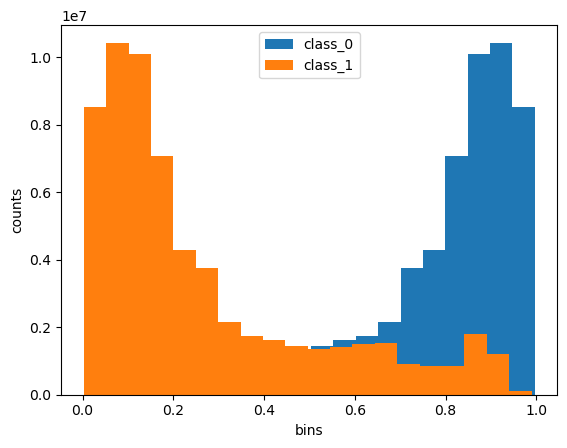

In [54]:
# Создание новой фигуры и осей
fig, ax = plt.subplots() 

# Построение данных на каждой оси
ax.hist(y_pred_all_0_pd, bins = 20, label = 'class_0')
ax.hist(y_pred_all_1_pd, bins = 20, label = 'class_1')

# Установка меток осей y
ax.set_xlabel('bins')
ax.set_ylabel('counts')
ax.legend()

plt.show()

Text(0.5, 1.0, 'scores')

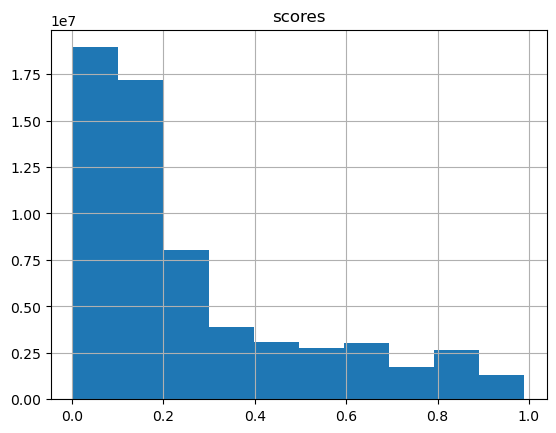

In [55]:
pd.DataFrame(y_pred_all).hist()
plt.title('scores')

In [58]:
df_PD['week_of_year'].max()

38

In [74]:
df_volume = df_PD[df_PD['target'].isna() == False][df_PD['week_of_year'] == 36][model_features]
print(df_volume.shape)
df_volume.head(3)

/tmp/ipykernel_11533/879983012.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_volume = df_PD[df_PD['target'].isna() == False][df_PD['week_of_year'] == 36][model_features]


(3652525, 26)


,gprs_mb_3_H_avg_gr30_sum,gprs_mb_3_H_avg,voice_min_1_H_avg_gr30_sum,voice_min_1_R_avg,voice_min_2_H_avg_gr30_sum,price_plan_type_max_Other,active_days_sum,price_plan_type_max_Bundle,voice_min_2_H_avg,voice_min_2_R_avg_gr30_sum,...,subs_market_cd_vip,voice_min_2_R_avg,price_plan_type_max_Line,subs_market_cd_ekt,gprs_mb_3_R_avg_gr30_sum,subs_market_cd_kzn,price_plan_type_max_Data,subs_market_cd_ufa,subs_market_cd_spb,calls_sum
14,5,454.015558,5,0.294444,5,0,7.0,1,1.601852,5,...,1.0,5.655556,0,0.0,0,0.0,0,0.0,0.0,0.0
31,3,553.744287,5,0.000000,5,0,6.0,1,0.945238,0,...,1.0,0.000000,0,0.0,0,0.0,0,0.0,0.0,0.0
48,5,70.671431,6,0.000000,2,0,7.0,1,14.171429,2,...,1.0,0.000000,0,0.0,0,0.0,0,0.0,0.0,0.0


In [75]:
y_vol = df_PD[df_PD['target'].isna() == False][df_PD['week_of_year'] == 36]['target']
len(y_vol)

/tmp/ipykernel_11533/2612792598.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_vol = df_PD[df_PD['target'].isna() == False][df_PD['week_of_year'] == 36]['target']


3652525

Text(0.5, 1.0, 'score')

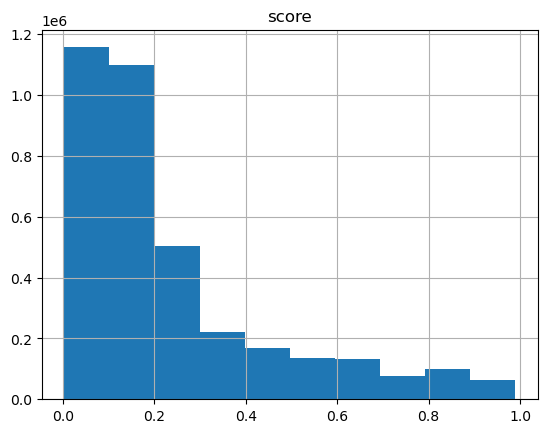

In [76]:
y_pred_vol = clf_lgb.predict_proba(df_volume)[:,1]
pd.DataFrame(y_pred_vol).hist()
plt.title('score')

In [77]:
y_pred_all_df = pd.DataFrame(y_pred_vol)
y_pred_all_df.rename(columns = {0: 'predict'}, inplace = True)
y_pred_all_df.head()

,predict
0,0.193381
1,0.307008
2,0.162872
3,0.173524
4,0.338289


In [78]:
print(len(y_vol))

3652525


In [79]:
print(y_pred_all_df.shape)

(3652525, 1)


In [80]:
y_pred_all_01_i = y_pred_all_df['predict'].apply(lambda x: 1 if x >= 0.5 else 0)
len(y_pred_all_01_i)

3652525

In [81]:
metrics.confusion_matrix(y_vol, y_pred_all_01_i)

array([[3149597,  501733],
       [    870,     325]])

In [82]:
def dependency_volume_threshold(y_pred_all):

    list_thresholds, list_number = [], []
    
    # for th_i in range(0, 10):
    for th_i in range(1, 10):

        th_i = th_i / 10

        y_pred_all_01_i = y_pred_all_df['predict'].apply(lambda x: 1 if x >= th_i else 0)
        
        confusion_i = metrics.confusion_matrix(y_vol, y_pred_all_01_i)

        TP_i, FP_i, TN_i, FN_i = confusion_i[1,1], confusion_i[0,1], confusion_i[0,0], confusion_i[1,0]
        number_i = TP_i + FP_i
        list_thresholds.append(th_i)
        list_number.append(number_i)

    d = {'thresholds': list_thresholds, 'number': list_number}
    df_th_num = pd.DataFrame(d)

    return df_th_num
        
df_th_num = dependency_volume_threshold(y_pred_all_df)
df_th_num

,thresholds,number
0,0.1,2520841
1,0.2,1400597
2,0.3,892072
3,0.4,669938
4,0.5,502058
5,0.6,362961
6,0.7,227552
7,0.8,154762
8,0.9,45814


Text(0.5, 0, 'threshold')

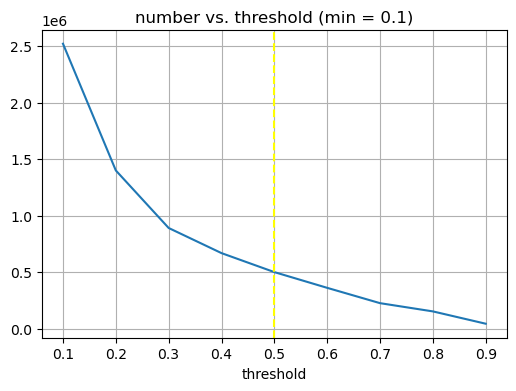

In [83]:
# df_th_num.plot()

plt.figure(figsize = (6, 4))

plt.plot(df_th_num['thresholds'], df_th_num['number'])
plt.axvline(x = 0.5, color = 'yellow', linestyle = '--')

plt.grid()
plt.title('number vs. threshold (min = 0.1)')
plt.xlabel("threshold")

Text(0.5, 0, 'threshold')

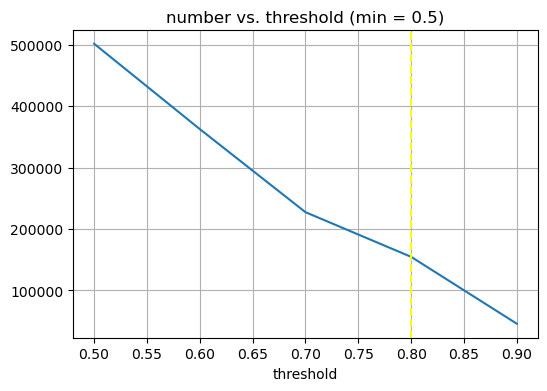

In [84]:
plt.figure(figsize = (6, 4))

plt.plot(df_th_num[df_th_num['thresholds'] >= 0.5]['thresholds'], 
         df_th_num[df_th_num['thresholds'] >= 0.5]['number'])

plt.axvline(x = 0.8, color = 'yellow', linestyle = '--')

plt.grid()
plt.title('number vs. threshold (min = 0.5)')
plt.xlabel("threshold")

In [87]:
y_pred_all_df['predict'].max()

0.9894642457928224

In [89]:
def dependency_volume_threshold(y_pred_all):

    list_thresholds, list_number = [], []
    
    # for th_i in range(0, 10):
    for th_i in np.arange(9, 10.1, 0.1):

        th_i = th_i / 10

        y_pred_all_01_i = y_pred_all_df['predict'].apply(lambda x: 1 if x >= th_i else 0)
        
        confusion_i = metrics.confusion_matrix(y_vol, y_pred_all_01_i)

        TP_i, FP_i, TN_i, FN_i = confusion_i[1,1], confusion_i[0,1], confusion_i[0,0], confusion_i[1,0]
        number_i = TP_i + FP_i
        list_thresholds.append(th_i)
        list_number.append(number_i)

    d = {'thresholds': list_thresholds, 'number': list_number}
    df_th_num = pd.DataFrame(d)

    return df_th_num
        
df_th_num = dependency_volume_threshold(y_pred_all_df)
df_th_num

,thresholds,number
0,0.90,45814
1,0.91,37749
2,0.92,24512
3,0.93,13950
4,0.94,7867
5,0.95,4789
6,0.96,2616
7,0.97,179
8,0.98,24
9,0.99,0
